In [4]:
import numpy as np
from matplotlib import pyplot as plt

CUC 的主类

In [38]:
from sklearn.model_selection import train_test_split

class CUC(object):
    '编码单元分类器'
    def __init__(self, num_continuing_splits=0, max_CU_splits=0, is_draw_2D=False, **kw) -> None:
        """初始化

        Args:
            num_continuing_splits (int, optional): 细化分割次数. Defaults to 0.
            max_CU_splits (int, optional): 最大递归次数. Defaults to 0.
            is_draw_2D (bool, optional): 当绘制 2D 数据集，是否绘制中途图像. Defaults to False.
        """
        self.__is_draw_2D = is_draw_2D
        self.__num_continuing_splits = num_continuing_splits
        self.__max_CU_splits = max_CU_splits
        self.__X_train = None
        self.__y_train = None
        
        self.target = None  # 特征提取后的目标值
        self.target_names = None  # 目标值（种类）对应的名称
        
        def train_test_split(X, y, test_size=0.25, random_state=None):
            pass
            
        
        def MinMaxScaler():
            pass
        
        def StandardScaler():
            pass
        
        
        
        # def 

ModuleNotFoundError: No module named 'sklearn.model_selection.train_test_split'

绘制 CU

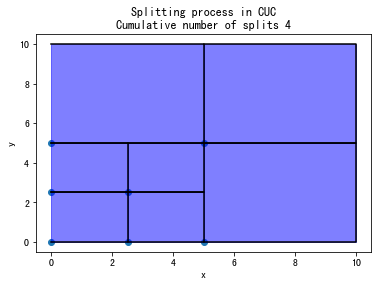

In [8]:
# 第一为：CU起始点的x
# 第二为：CU起始点的y
# 第三为：CU 的边长
data = np.array([
    [0,   0,   2.5],
    [2.5, 0,   2.5],
    [0,   2.5, 2.5],
    [2.5, 2.5, 2.5],
    [0,   5,   5],
    [5,   0,   5],
    [5,   5,   5]])

plt.figure()
plt.scatter(data[:, 0], data[:, 1])
# plt.show()

num = 4

# plt.figure()
for i in data:
    t_x_block = [i[0], i[0]+i[2], i[0]+i[2], i[0]]
    t_y_block = [i[1], i[1],      i[1]+i[2], i[1]+i[2]]
    plt.plot(t_x_block, t_y_block, c='black')
    plt.fill(t_x_block, t_y_block, c='b', alpha=0.5)
    plt.title(f'Splitting process in CUC\nCumulative number of splits {num}')
    plt.ylabel('y')
    plt.xlabel('x')
plt.show()

In [30]:
def generate_combinations(arr1, arr2):
    # 获取数组长度
    n = len(arr1)
    # 生成包含所有可能性组合的列表
    combinations = []
    for i in range(2**n):
        new_combination = []
        for j in range(n):
            if i & (1<<j):
                new_combination.append(arr2[j])
            else:
                new_combination.append(arr1[j])
        combinations.append(new_combination)
    return combinations


In [31]:
generate_combinations(["x1", "y1", "z1"], ["x2", "y2", "z2"])

[['x1', 'y1', 'z1'],
 ['x2', 'y1', 'z1'],
 ['x1', 'y2', 'z1'],
 ['x2', 'y2', 'z1'],
 ['x1', 'y1', 'z2'],
 ['x2', 'y1', 'z2'],
 ['x1', 'y2', 'z2'],
 ['x2', 'y2', 'z2']]

In [32]:
generate_combinations(["0", "0", "0"], ["1", "1", "1"])

[['0', '0', '0'],
 ['1', '0', '0'],
 ['0', '1', '0'],
 ['1', '1', '0'],
 ['0', '0', '1'],
 ['1', '0', '1'],
 ['0', '1', '1'],
 ['1', '1', '1']]

In [37]:
from sklearn import datasets
from sklearn import model_selection

{'data': array([[5.1, 3.5, 1.4, 0.2],
        [4.9, 3. , 1.4, 0.2],
        [4.7, 3.2, 1.3, 0.2],
        [4.6, 3.1, 1.5, 0.2],
        [5. , 3.6, 1.4, 0.2],
        [5.4, 3.9, 1.7, 0.4],
        [4.6, 3.4, 1.4, 0.3],
        [5. , 3.4, 1.5, 0.2],
        [4.4, 2.9, 1.4, 0.2],
        [4.9, 3.1, 1.5, 0.1],
        [5.4, 3.7, 1.5, 0.2],
        [4.8, 3.4, 1.6, 0.2],
        [4.8, 3. , 1.4, 0.1],
        [4.3, 3. , 1.1, 0.1],
        [5.8, 4. , 1.2, 0.2],
        [5.7, 4.4, 1.5, 0.4],
        [5.4, 3.9, 1.3, 0.4],
        [5.1, 3.5, 1.4, 0.3],
        [5.7, 3.8, 1.7, 0.3],
        [5.1, 3.8, 1.5, 0.3],
        [5.4, 3.4, 1.7, 0.2],
        [5.1, 3.7, 1.5, 0.4],
        [4.6, 3.6, 1. , 0.2],
        [5.1, 3.3, 1.7, 0.5],
        [4.8, 3.4, 1.9, 0.2],
        [5. , 3. , 1.6, 0.2],
        [5. , 3.4, 1.6, 0.4],
        [5.2, 3.5, 1.5, 0.2],
        [5.2, 3.4, 1.4, 0.2],
        [4.7, 3.2, 1.6, 0.2],
        [4.8, 3.1, 1.6, 0.2],
        [5.4, 3.4, 1.5, 0.4],
        [5.2, 4.1, 1.5, 0.1],
  